## Data Understanding

In [1]:
#importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import boto3

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [2]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [3]:
#pd.options.display.max_columns = None
pd.set_option('display.max_columns', None)


In [4]:
s3_csv_path = f's3://group5-porter-delivery-estimation/data/dataset.csv'

df = pd.read_csv(s3_csv_path)

In [5]:
#Information of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

In [6]:
#First 3 rows of table

df.loc[:df.index[2]]


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0


In [7]:
#year,month and day for 'created_at'

df[['year', 'month', 'day']] = df['created_at'].str.split('-', expand=True)
df['day'] = df['day'].str.split(' ', expand=True)[0]
df[['year', 'month', 'day']] = df[['year', 'month', 'day']].astype(int)



In [8]:
#created_at & actual_delivery_time into date_time format conversion
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])


In [9]:
#feature'time_taken(mins)' created to store the time taken for delivery in minutes
df['time_taken(mins)'] = (df['actual_delivery_time'] - df['created_at']).astype('timedelta64[m]')

In [10]:
#created_at and actual_deivery_time dropping
df = df.drop(columns=['created_at', 'actual_delivery_time'])


In [11]:
#make a copy for exploration
df_=df.copy()

### Exploratory Data Analysis

In [12]:
#missing values percentage in each category
percent_missing = df_.isnull().sum() * 100 / len(df_)
missing_value_df = pd.DataFrame({'%age of missing value': percent_missing})
missing_value_df.index.name = 'feature'
missing_value_df = missing_value_df.reset_index()


In [13]:
#categorical and numerical features splitting
categorical_feature = []
numerical_feature = []

for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'category':
        categorical_feature.append(col)
    else:
        numerical_feature.append(col)


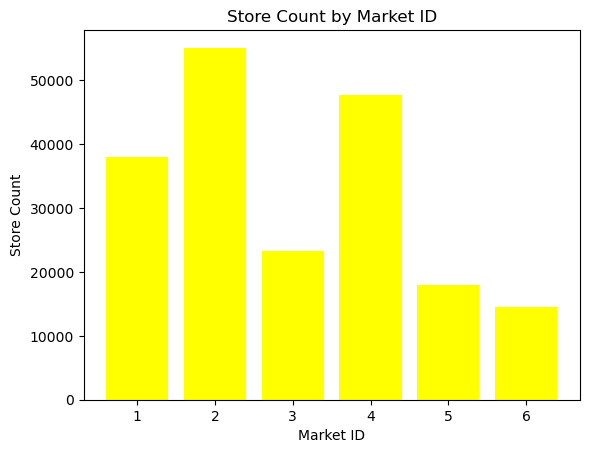

In [14]:
# total number of order from each market
store_count = df_.groupby('market_id')['store_id'].count()
plt.bar(store_count.index, store_count.values, color='yellow')
plt.xlabel('Market ID')
plt.ylabel('Store Count')
plt.title('Store Count by Market ID')
plt.show()


<AxesSubplot: xlabel='year', ylabel='count'>

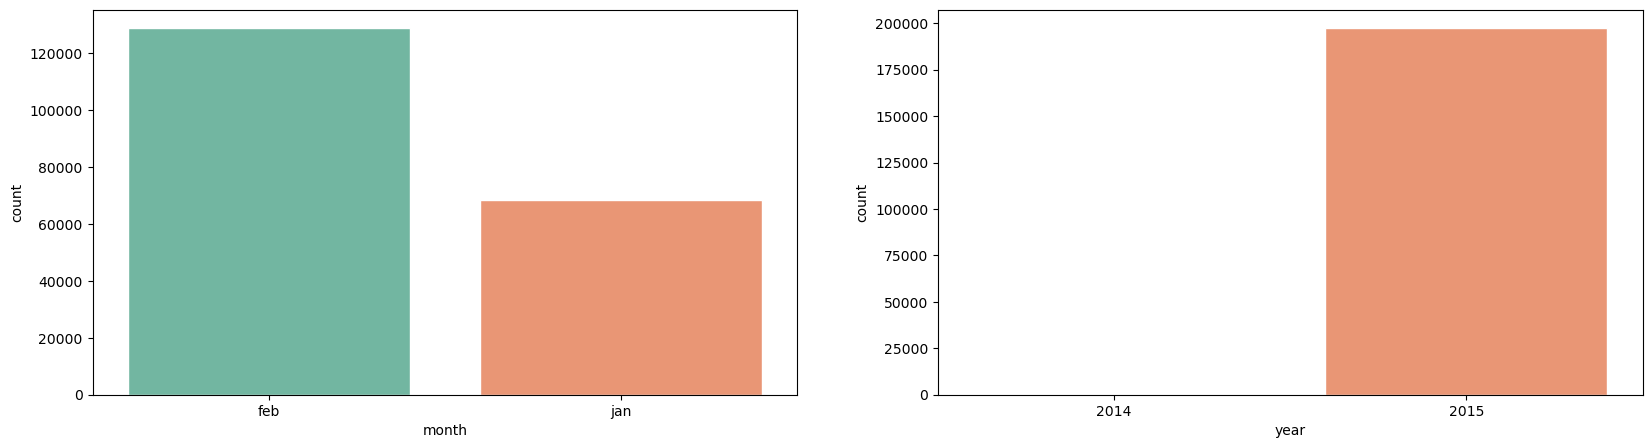

In [15]:
#Analysing what was the frequency of orders in each month and in year 2014 and 2015
df_['month']=df_['month'].map({1:'jan',2:'feb',3:'oct'})
fig=plt.figure(figsize=(20,5))
ax=[None for _ in range(2)]
ax[0]=plt.subplot2grid((1,2),(0,0))
ax[1]=plt.subplot2grid((1,2),(0,1))
sns.set_style('darkgrid')
sns.countplot(x='month',data=df_,palette='Set2',ax=ax[0])
sns.countplot(x='year',data=df_,palette='Set2',ax=ax[1])


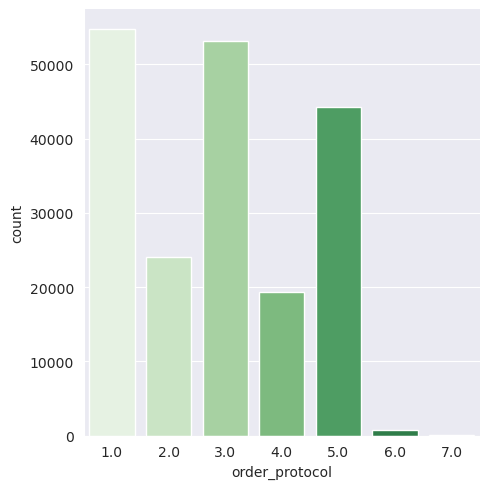

In [16]:
#ways in which different orders are placed(i.e., order protocol with most number of orders)
sns.catplot(x='order_protocol', kind='count', data=df_, palette='Greens')


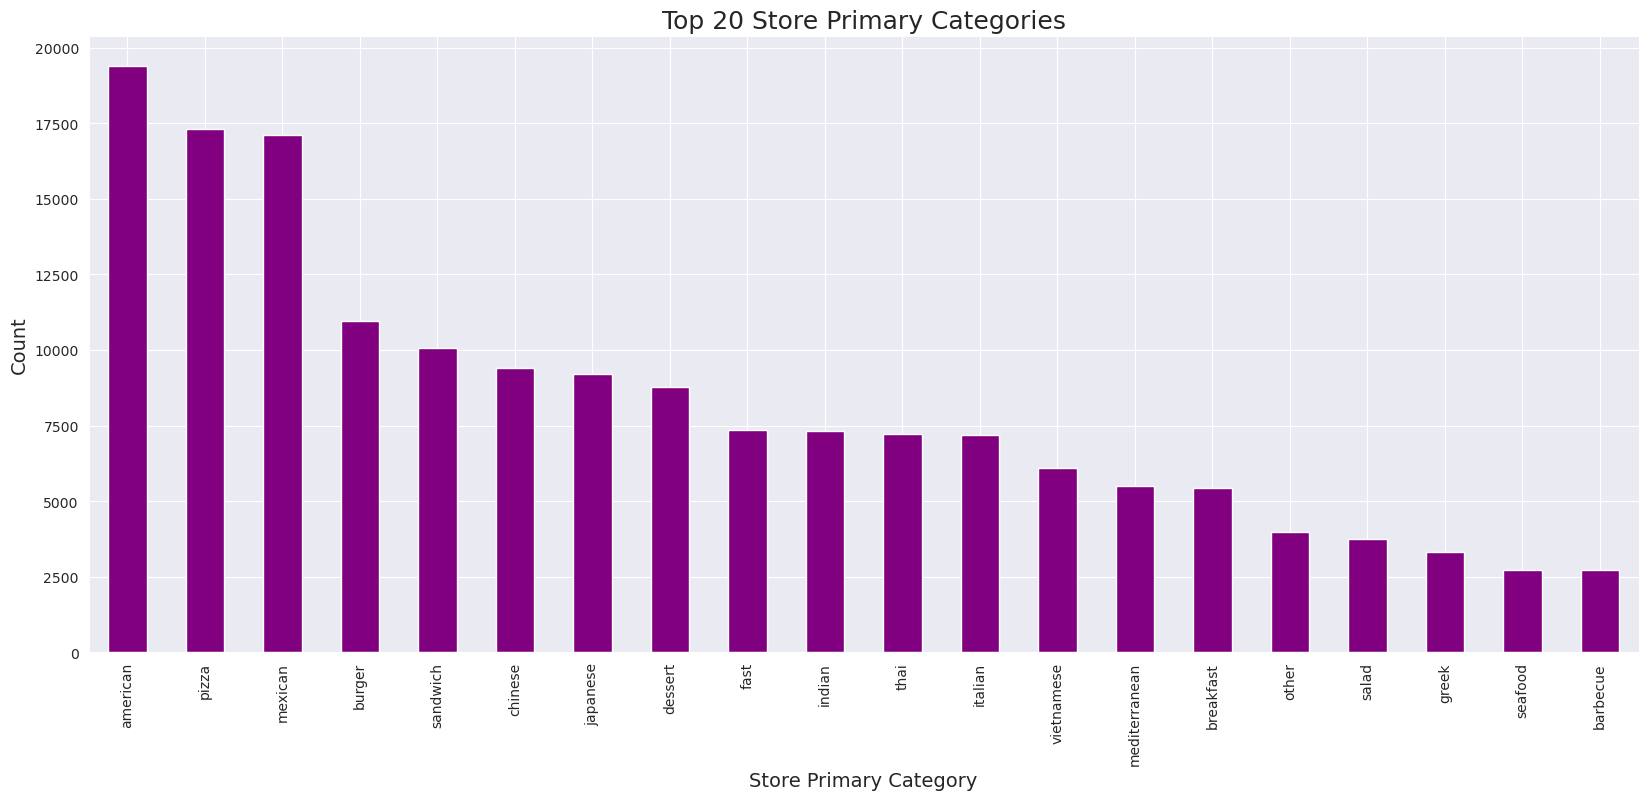

In [17]:
#top 20 i.e., most ordered category
fig, ax = plt.subplots(figsize=(20, 8))
df_['store_primary_category'].value_counts().sort_values(ascending=False)[:20].plot(kind='bar', ax=ax, color='purple')
ax.set_xlabel('Store Primary Category', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Top 20 Store Primary Categories', fontsize=18)
plt.show()



<AxesSubplot: xlabel='max_item_price'>

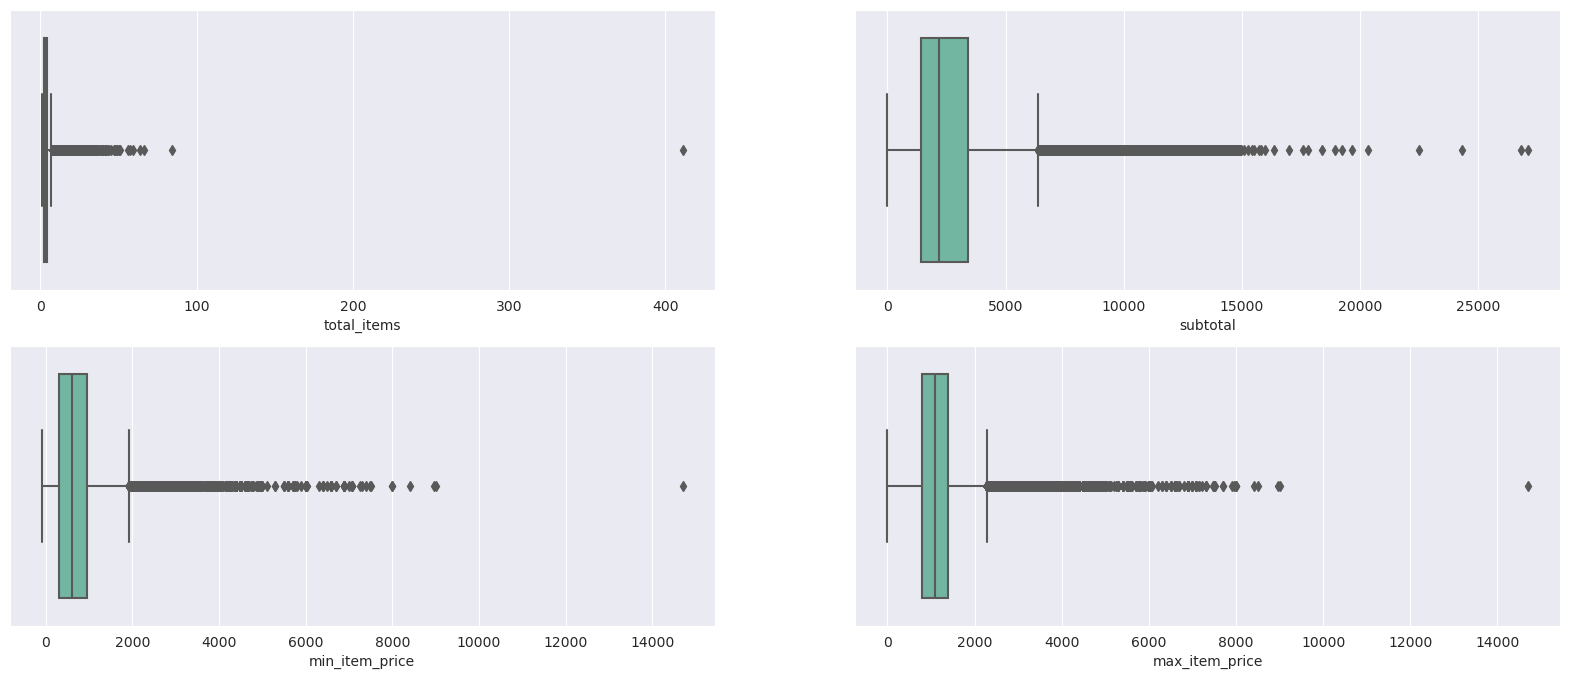

In [18]:
#Analysis of the numerical features 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))
sns.boxplot(x='total_items', data=df_, palette='Set2', ax=axes[0, 0])
sns.boxplot(x='subtotal', data=df_, palette='Set2', ax=axes[0, 1])
sns.boxplot(x='min_item_price', data=df_, palette='Set2', ax=axes[1, 0])
sns.boxplot(x='max_item_price', data=df_, palette='Set2', ax=axes[1, 1])



<AxesSubplot: xlabel='total_onshift_partners'>

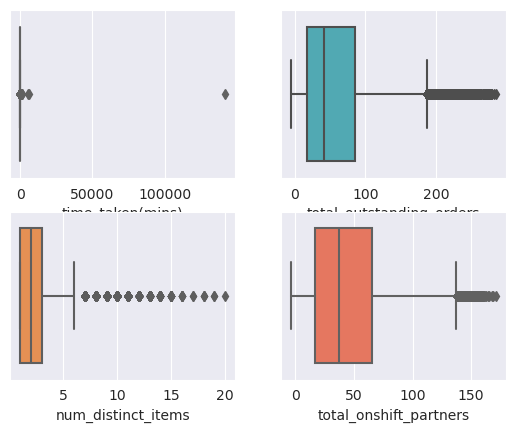

In [19]:
#fig=plt.figure(figsize=(20,8))
ax=[None for _ in range(4)]
ax[0]=plt.subplot2grid((2,2),(0,0))
ax[1]=plt.subplot2grid((2,2),(0,1))
ax[2]=plt.subplot2grid((2,2),(1,0))
ax[3]=plt.subplot2grid((2,2),(1,1))
sns.boxplot(x='time_taken(mins)',data=df_,palette='PuBu',ax=ax[0])
sns.boxplot(x='total_outstanding_orders',data=df_,palette='YlGnBu',ax=ax[1])
sns.boxplot(x='num_distinct_items',data=df_,palette='Oranges',ax=ax[2])
sns.boxplot(x='total_onshift_partners',data=df_,palette='Reds',ax=ax[3])



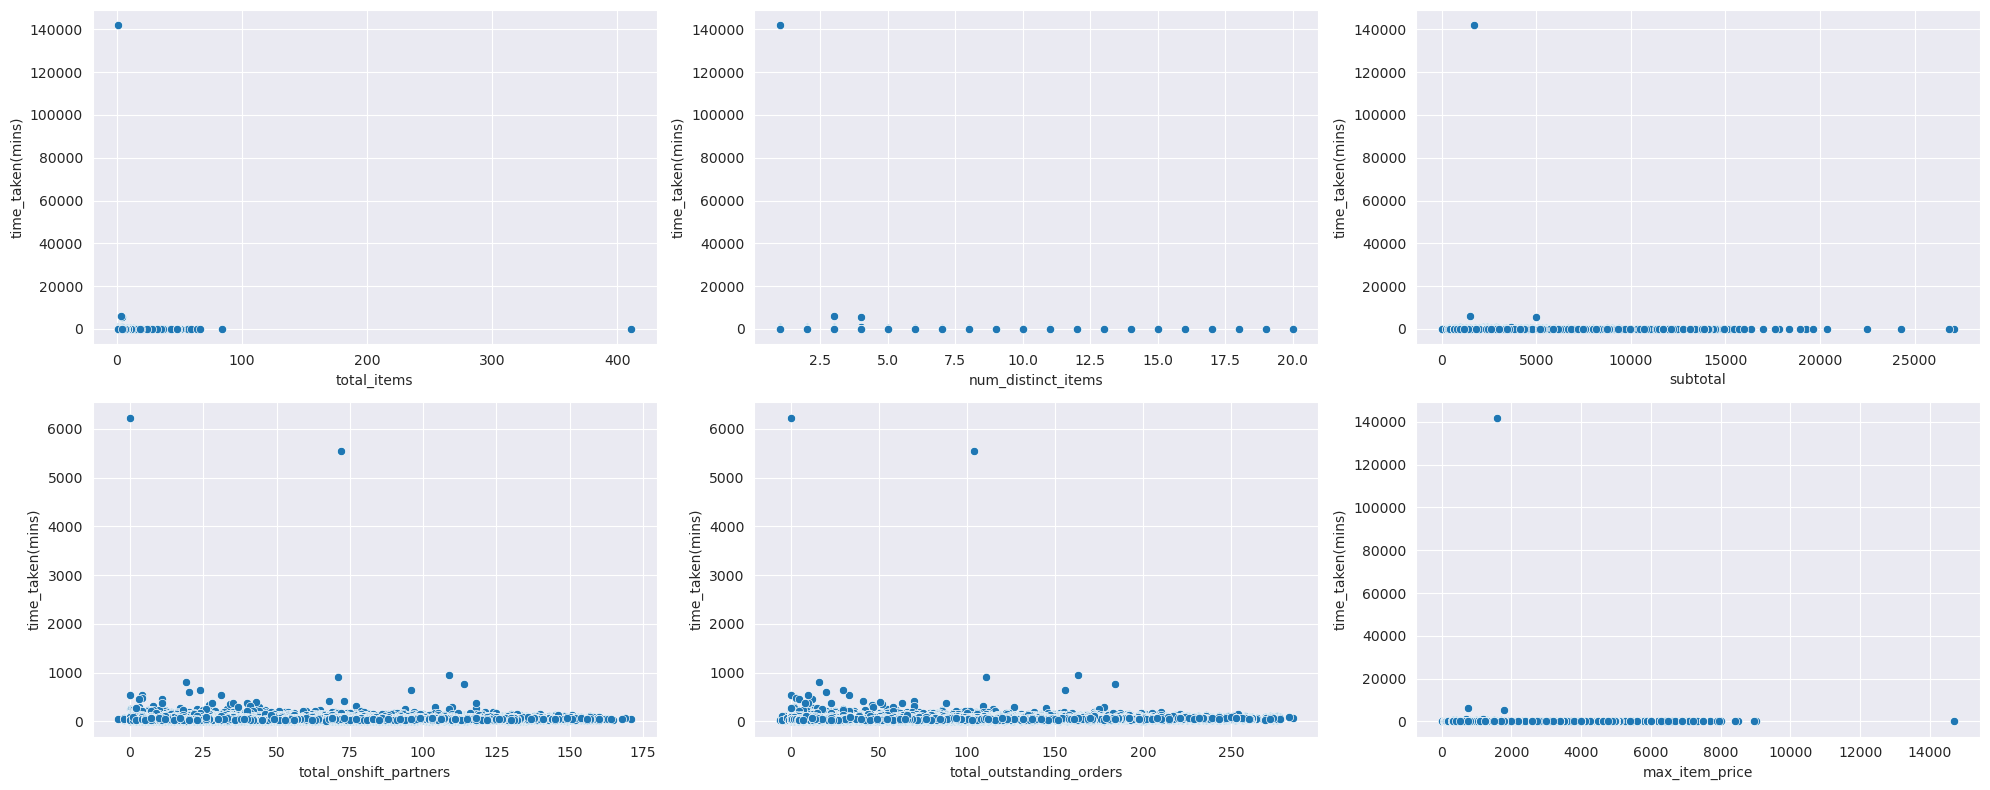

In [20]:
#bivariate analysis: to see how the other features are correlated with delivery time 'time_taken(mins)'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
sns.scatterplot(x='total_items', y='time_taken(mins)', data=df_, ax=axes[0, 0])
sns.scatterplot(x='num_distinct_items', y='time_taken(mins)', data=df_, ax=axes[0, 1])
sns.scatterplot(x='subtotal', y='time_taken(mins)', data=df_, ax=axes[0, 2])
sns.scatterplot(x='total_onshift_partners', y='time_taken(mins)', data=df_, ax=axes[1, 0])
sns.scatterplot(x='total_outstanding_orders', y='time_taken(mins)', data=df_, ax=axes[1, 1])
sns.scatterplot(x='max_item_price', y='time_taken(mins)', data=df_, ax=axes[1, 2])
plt.tight_layout()

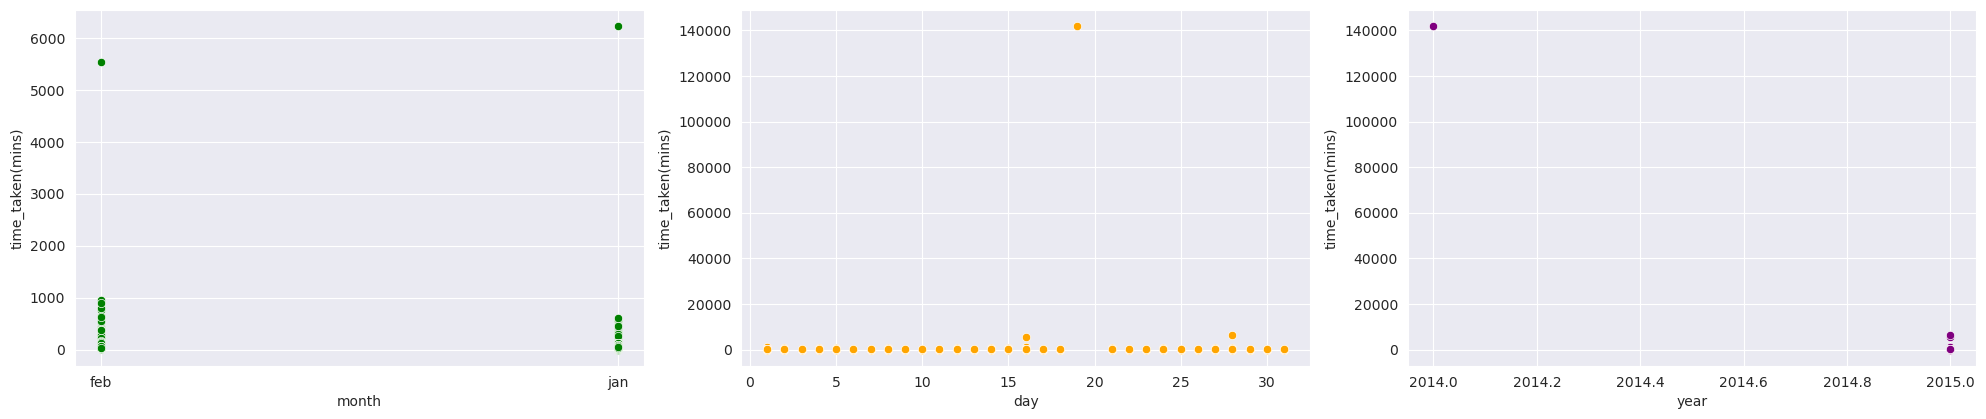

In [21]:
fig=plt.figure(figsize=(20,8))
ax=[None for _ in range(3)]
ax[0]=plt.subplot2grid((2,3),(0,0))
ax[1]=plt.subplot2grid((2,3),(0,1))
ax[2]=plt.subplot2grid((2,3),(0,2))
sns.scatterplot(x='month',y='time_taken(mins)',data=df_,color='green',ax=ax[0])
sns.scatterplot(x='day',y='time_taken(mins)',data=df_,color='orange',ax=ax[1])
sns.scatterplot(x='year',y='time_taken(mins)',data=df_,color='purple',ax=ax[2])
plt.tight_layout()


<AxesSubplot: >

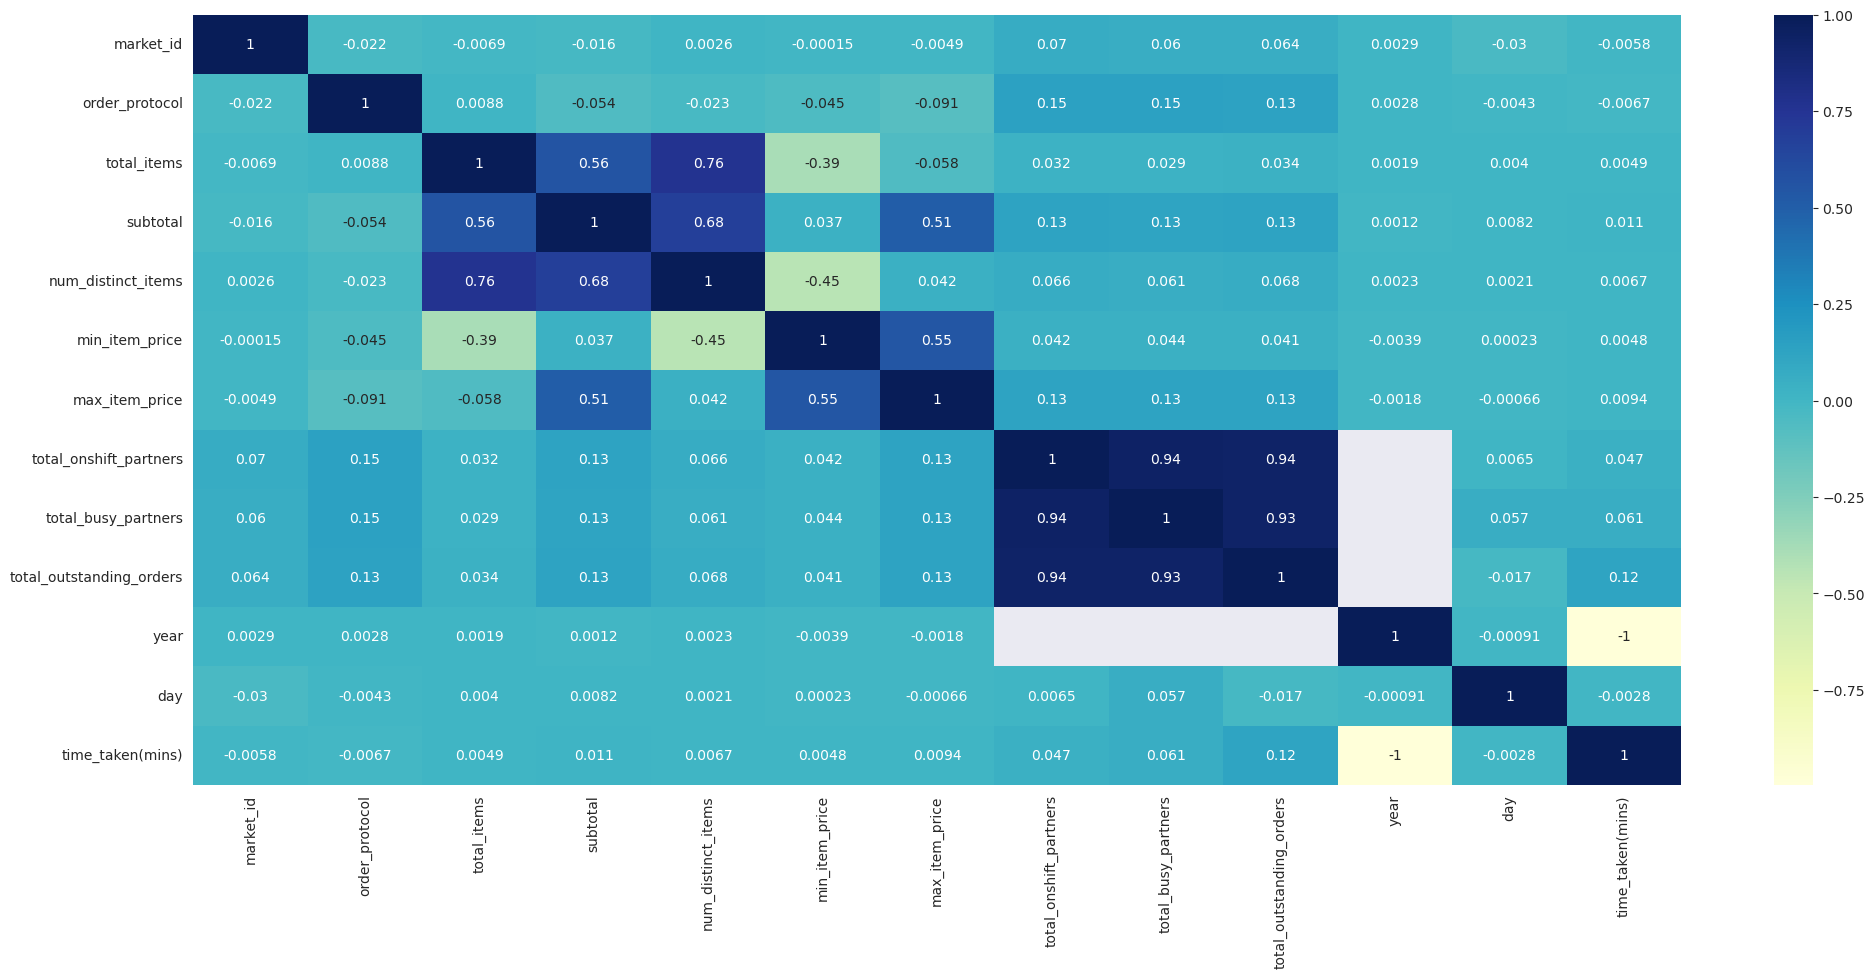

In [22]:
#correlation heatmap
plt.figure(figsize=(24,10))
sns.heatmap(df_.corr(), cmap='YlGnBu', annot=True, annot_kws={'size':10})



In [23]:
abs_corr = abs(df_.corr()['time_taken(mins)'])
sorted_corr = abs_corr.sort_values(ascending=False)
print(sorted_corr)


time_taken(mins)            1.000000
year                        0.996474
total_outstanding_orders    0.122261
total_busy_partners         0.060615
total_onshift_partners      0.046952
subtotal                    0.011203
max_item_price              0.009411
num_distinct_items          0.006743
order_protocol              0.006662
market_id                   0.005781
total_items                 0.004906
min_item_price              0.004764
day                         0.002843
Name: time_taken(mins), dtype: float64


# Data Prepocessing

In [24]:
df_.isna().sum()

market_id                     987
store_id                        0
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
year                            0
month                           1
day                             0
time_taken(mins)                7
dtype: int64

In [25]:
#imputing null values
df_['market_id']=np.where(df_['market_id'].isnull(),df_['market_id'].mode()[0],df_['market_id'])
df_['store_primary_category']=np.where(df_['store_primary_category'].isnull(),df['store_primary_category'].mode()[0],df_['store_primary_category'])
df_['order_protocol']=np.where(df_['order_protocol'].isnull(),df['order_protocol'].mode()[0],df_['order_protocol'])
df_['total_onshift_partners']=np.where(df_['total_onshift_partners'].isnull(),df['total_onshift_partners'].mean(),df_['total_onshift_partners'])
df_['total_busy_partners']=np.where(df_['total_busy_partners'].isnull(),df['total_busy_partners'].mean(),df_['total_busy_partners'])
df_['total_outstanding_orders']=np.where(df_['total_outstanding_orders'].isnull(),df['total_outstanding_orders'].mean(),df_['total_outstanding_orders'])
df_['time_taken(mins)']=np.where(df_['time_taken(mins)'].isnull(),df['time_taken(mins)'].mean(),df_['time_taken(mins)'])

In [26]:
df_.describe()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,year,day,time_taken(mins)
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,2.973813,2.872865,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,2014.999995,15.296721,47.979192
std,1.522616,1.505888,2.666546,1823.093688,1.630255,522.038648,558.411377,33.074249,30.793369,50.446359,0.002251,9.200962,320.487546
min,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,2014.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,19.000000,17.000000,19.000000,2015.000000,7.000000,35.000000
50%,3.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,41.000000,39.000000,47.000000,2015.000000,14.000000,44.000000
75%,4.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,62.000000,59.000000,80.000000,2015.000000,24.000000,56.000000
max,6.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2015.000000,31.000000,141947.000000


In [27]:
#we can see that in min_item_price column the min is -86, since it describes the price it can't be negative, we need to remove these values
df_ = df_[df_['min_item_price'] >= 0]


In [28]:
#similarly total_outstanding_order describe the number of pending orders and again it can't be negative
df_ = df_[df_['total_outstanding_orders'] >= 0]


In [29]:
#same goes for total_busy_partners and total_onshift_partners
mask = (df_['total_onshift_partners'] >= 0) & (df_['total_busy_partners'] >= 0)
df_ = df_[mask]


In [30]:
#separating categorical and numerical_variables
df_num = df_.select_dtypes(include=np.number)
df_cat = df_.select_dtypes(include='object')


In [31]:
df_.select_dtypes(include=np.number).head()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,year,day,time_taken(mins)
0,1.0,1.0,4,3441,4,557,1239,33.0,14.0,21.0,2015,6,62.0
1,2.0,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,2015,10,67.0
2,3.0,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,2015,22,29.0
3,3.0,1.0,6,6900,5,600,1800,1.0,1.0,2.0,2015,3,51.0
4,3.0,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,2015,15,39.0


In [32]:
#applying log_transformation on df_num
time_taken=df_num['time_taken(mins)']
df_num.drop('time_taken(mins)',axis=1,inplace=True)
df_num = np.log1p(df_num)

In [33]:
#encoding categorical features
df_.select_dtypes(include='object').head(3)


,store_id,store_primary_category,month
0,df263d996281d984952c07998dc54358,american,feb
1,f0ade77b43923b38237db569b016ba25,mexican,feb
2,f0ade77b43923b38237db569b016ba25,american,jan


In [34]:
df_cat.drop('store_id',axis=1,inplace=True)
encoder=LabelEncoder()
for feature in df_cat.columns:
    df_cat[feature]=encoder.fit_transform(df_cat[feature])

In [35]:
#concatenating back the numerical and categorical features
df_new_ = df_num.join(df_cat)

In [36]:
df_new_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197334 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 197334 non-null  float64
 1   order_protocol            197334 non-null  float64
 2   total_items               197334 non-null  float64
 3   subtotal                  197334 non-null  float64
 4   num_distinct_items        197334 non-null  float64
 5   min_item_price            197334 non-null  float64
 6   max_item_price            197334 non-null  float64
 7   total_onshift_partners    197334 non-null  float64
 8   total_busy_partners       197334 non-null  float64
 9   total_outstanding_orders  197334 non-null  float64
 10  year                      197334 non-null  float64
 11  day                       197334 non-null  float64
 12  store_primary_category    197334 non-null  int64  
 13  month                     197334 non-null  i

In [37]:
X=df_new_.copy()
y=time_taken

In [38]:
#train test split
train_mask = np.random.rand(len(X)) < 0.3
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

In [39]:
from xgboost import XGBRegressor
xgb=XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [40]:
y_pred=xgb.predict(X_test)
print('Mean absolute error:{}'.format(mean_absolute_error(y_test,y_pred)))
print('r2_score:{}'.format(r2_score(y_test,y_pred)))

Mean absolute error:12.828135421180502
r2_score:0.0005775778642763685


# Factors Influencing Delivery Time:

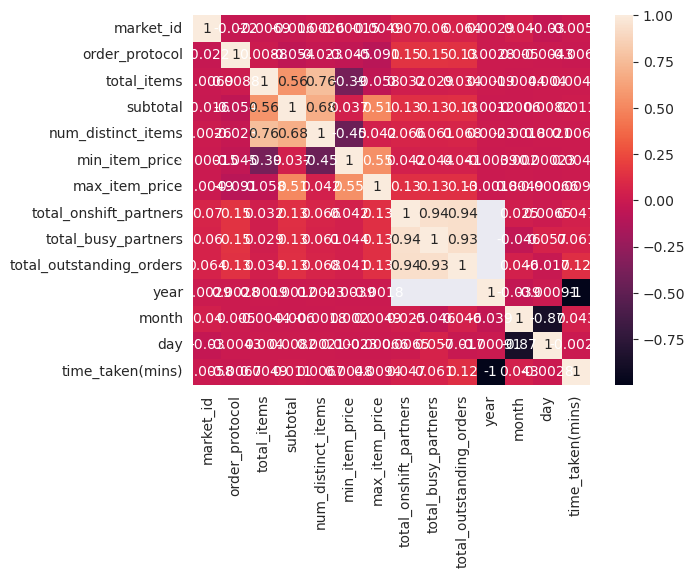

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize correlation between features
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Impact of Order Protocol:

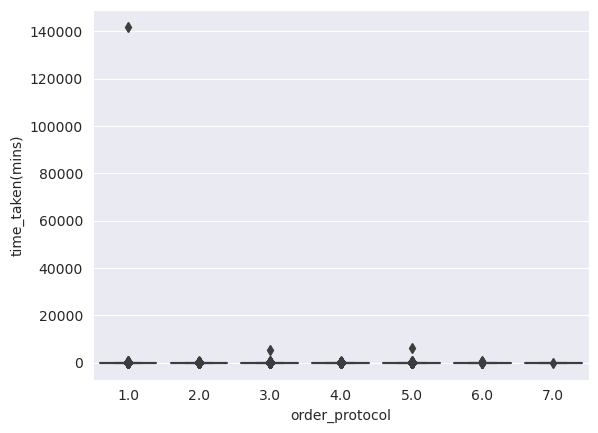

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare delivery time distribution based on order protocols
sns.boxplot(data=df, x='order_protocol', y='time_taken(mins)')
plt.show()


# Restaurant Category and Order Size:

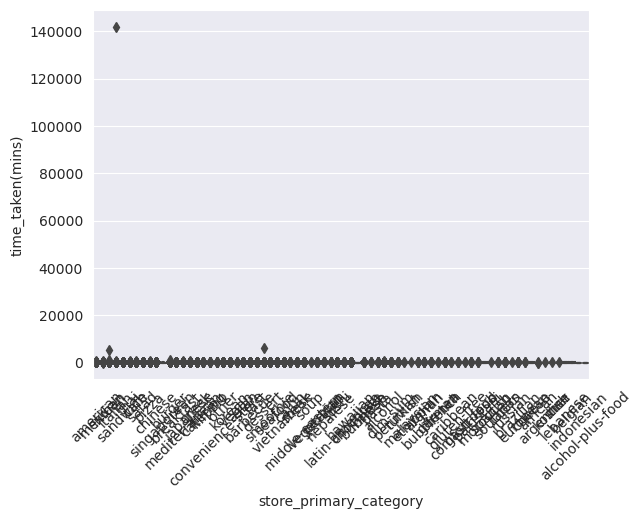

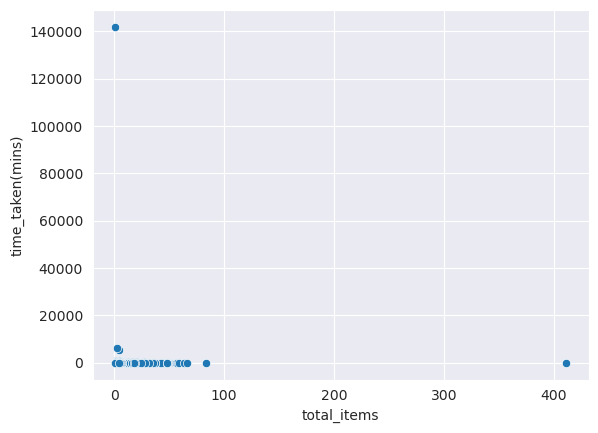

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare delivery time distribution based on restaurant category
sns.boxplot(data=df, x='store_primary_category', y='time_taken(mins)')
plt.xticks(rotation=45)
plt.show()

# Compare delivery time distribution based on order size
sns.scatterplot(data=df, x='total_items', y='time_taken(mins)')
plt.show()


# Prices of Items in an Order:

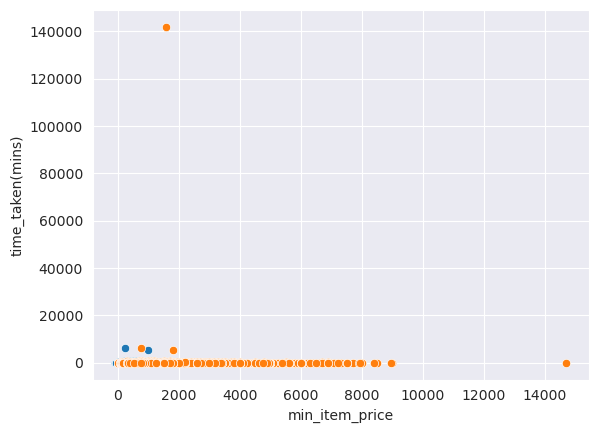

In [44]:
import seaborn as sns

# Analyze relationship between item prices and delivery time
sns.scatterplot(data=df, x='min_item_price', y='time_taken(mins)')
sns.scatterplot(data=df, x='max_item_price', y='time_taken(mins)')
plt.show()


# On-Shift and Busy Delivery Partners:

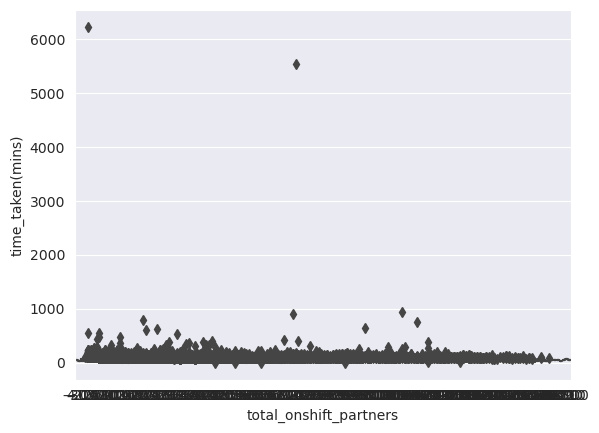

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare delivery time distribution based on number of on-shift and busy delivery partners
sns.boxplot(data=df, x='total_onshift_partners', y='time_taken(mins)')
plt.show()


# Seasonal and Time-Based Trends:

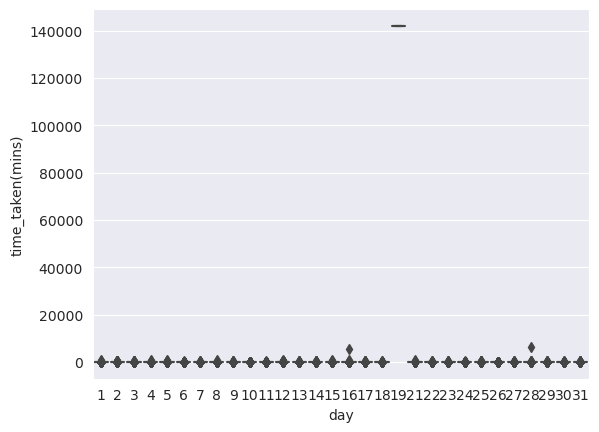

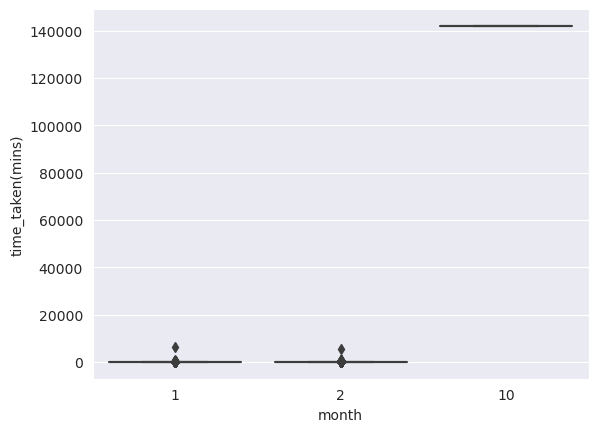

In [46]:

# Compare delivery time distribution based on day of the week
sns.boxplot(data=df, x='day', y='time_taken(mins)')
plt.show()

# Compare delivery time distribution based on month of the year
sns.boxplot(data=df, x='month', y='time_taken(mins)')
plt.show()


# Customer Behavior Patterns:

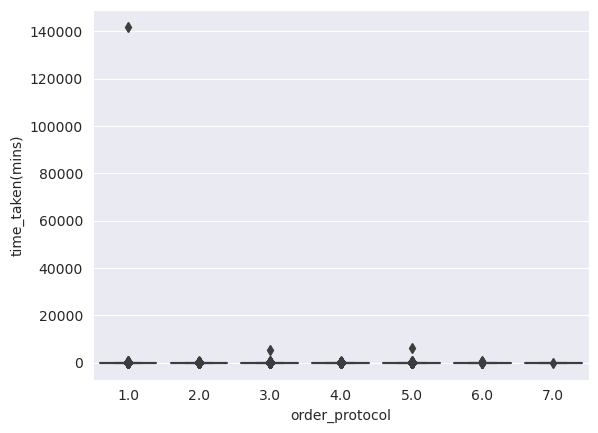

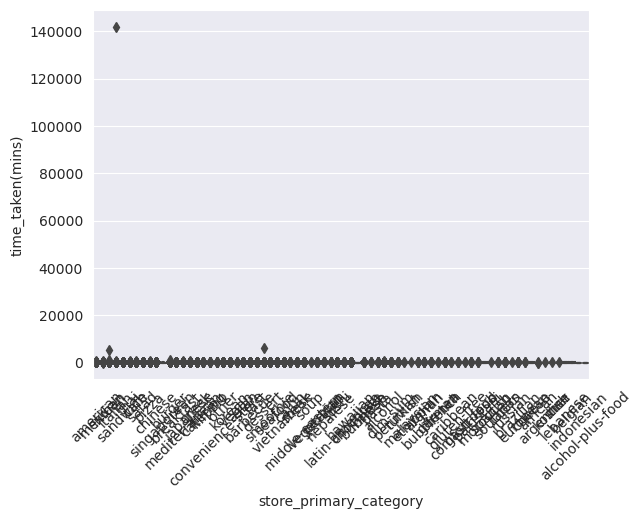

In [47]:

# Compare delivery time distribution based on order protocols or restaurant categories
sns.boxplot(data=df, x='order_protocol', y='time_taken(mins)')
plt.show()

sns.boxplot(data=df, x='store_primary_category', y='time_taken(mins)')
plt.xticks(rotation=45)
plt.show()


# Comparison of Markets Based on time taken

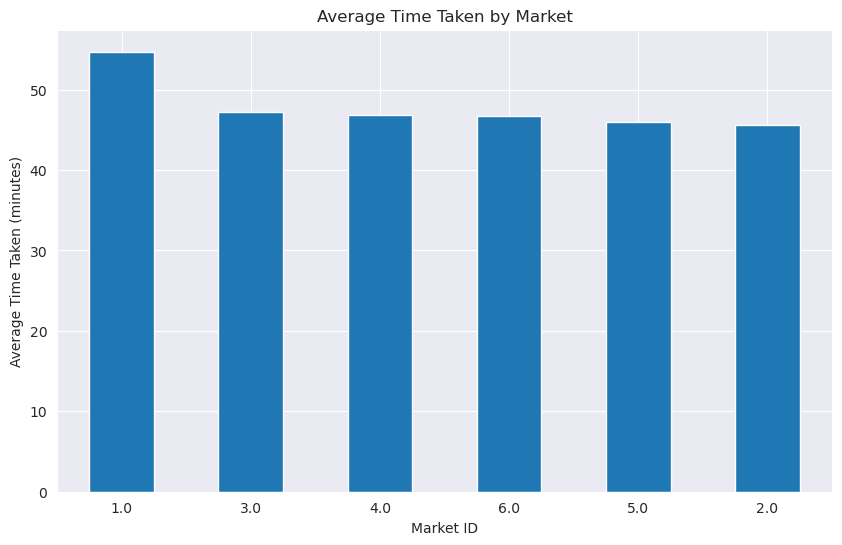

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame called 'df'
# Convert time_taken column to numeric format
df['time_taken(mins)'] = pd.to_numeric(df['time_taken(mins)'], errors='coerce')

# Group data by market and calculate average time taken
average_time_taken = df.groupby('market_id')['time_taken(mins)'].mean()

# Sort the average time taken in descending order
average_time_taken = average_time_taken.sort_values(ascending=False)

# Create a bar plot to compare the time taken for different markets
plt.figure(figsize=(10, 6))
average_time_taken.plot(kind='bar')
plt.xlabel('Market ID')
plt.ylabel('Average Time Taken (minutes)')
plt.title('Average Time Taken by Market')
plt.xticks(rotation=0)
plt.show()
